# Naive (for now) attempts to build DL manually

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We need to start with a test. What should this network fit?

To go beyond linear regression, let's consider a 2D case (x,y), and a non-linear landscape (a douhgnutty blob?).

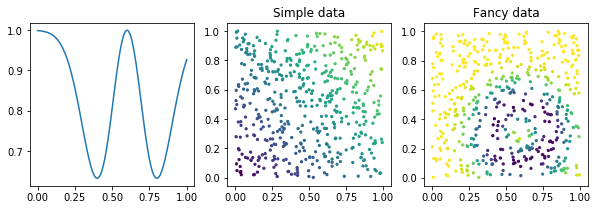

In [3]:
def target(xy, y=None, simple=False):
    if y is None:
        x = xy[:,0]
        y = xy[:,1]
    else:
        x = xy
    if simple:
        val = x+y
        val = val/max(val)
    else:
        d = np.sqrt((x-0.6)**2 + (y-0.3)**2)*5
        val = 1-np.exp(-d**2)*d**2
    return val

plt.figure(figsize=(10,3))
x = np.linspace(0,1,101)
plt.subplot(131)
plt.plot(x, target(x,0.3))

xy = np.random.uniform(size=(500,2))
z = target(xy, simple=True)
plt.subplot(132);
plt.scatter(xy[:,0], xy[:,1], s=5, c=z);
plt.title('Simple data');

xy = np.random.uniform(size=(500,2))
z = target(xy, simple=False)
plt.subplot(133);
plt.scatter(xy[:,0], xy[:,1], s=5, c=z);
plt.title('Fancy data');

Input dim = 2 (for one data point), and it seems to be a row. First layer then = n by 2 (assuming colum-vectors for vectors). Intermediate layers (if any): n1 by n2 (usually n2<n1). Last layer: 1 by m, as the output is only dim 1.

In [104]:
class Layer():
    """Neural Network Layer."""
    def __init__(self,m,n,alpha=0.01): # Dimensions are given in the order of logical human transformation: m-vec to n-vec
        self.w = np.random.randn(n,m)*np.sqrt(2/m) # He2015 init: var = 2/size_in
        self.b = np.random.randn(n)
        self.input  = np.zeros(m)
        self.out = np.zeros(n)
        self.left_error = np.zeros(m) # For backprop
        self.alpha = alpha            # Learning rate
        
    def __str__(self):
        return 'W:' + str(self.w) + ";\n B:" + str(self.b)
    
    def shape(self):
        return self.w.shape[::-1]
    
    def run(self,x):
        """Forward run."""
        # if type(x)==list:   x = np.array(x)
        self.input = x.copy()               # Deepcopy, as we need values, not the reference
        if len(x)!=self.w.shape[1]:
            error("Dimensions don't match")
        self.out = np.maximum(0 , np.matmul(self.w , x) + self.b)
        return self.out.copy()              # Isolating copies at return
    
    def backprop(self,y):
        """Backprop."""
        self.left_error = np.matmul(self.w.T, y)
        self.w += np.outer(self.input , y*(self.out>0)).T *self.alpha
        return self.left_error.copy()
        
        
# Tests
np.random.seed(3)
l = Layer(2,2)
print('Layer:',l)
print('Run 1:',l.run([1,-2]))
print('Backprop:',l.backprop(np.array([-1,1])))
print('Run 2:',l.run([1,-2]))

Layer: W:[[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]];
 B:[-0.2773882  -0.35475898]
Run 1: [0.63822057 3.4687239 ]
Backprop: [-1.69213101 -2.30000255]
Run 2: [0.58822057 3.5187239 ]


In [195]:
class Network():
    """Full neural network"""
    def __init__(self,depth,nstart,nend,alpha=0.01):
        if depth==1:
            self.layers = [Layer(nstart,nend)]
        else:
            hi = nstart*depth
            self.layers = []
            self.layers.append(Layer(nstart,hi,alpha))
            seq = [int(round(i)) for i in np.linspace(hi,nend,depth)]
            for i in range(depth-1):
                self.layers.append(Layer(seq[i],seq[i+1],alpha))
    
    def __str__(self):
        out = ''.join(['Layer '+str(l.shape())+f" α={l.alpha};\n" for l in self.layers])
        return out
    
    def process(self,X):
        out = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            out[i] = self.run(X[i,:])
        return out
    
    def run(self,x):
        y = x.copy()
        for l in self.layers:
            y = l.run(y)
        return y
    
    def step(self,x,y):
        """Training step"""
        yhat = self.run(x)
        loss = np.linalg.norm(yhat-y)
        e = y-yhat
        for l in self.layers[::-1]:
            e = l.backprop(e)
        return loss
    
    def train(self,xmat,ymat,n=1):
        loss = []
        buffer = np.array([])
        for k in range(n):
            for i in range(len(ymat)):
                buffer = np.hstack((buffer,self.step(xmat[i,:],ymat[i])))
                if i % 100 == 0:
                    loss.append(np.mean(buffer))
                    buffer = np.array([])
        return loss

In [196]:
# Network creation
mynet = Network(depth=4,nstart=2, nend=1, alpha=0.001)
loss_history = np.array([])
print(mynet)
mynet.run([2,3])

Layer (2, 8) α=0.001;
Layer (8, 6) α=0.001;
Layer (6, 3) α=0.001;
Layer (3, 1) α=0.001;



array([1.95279013])

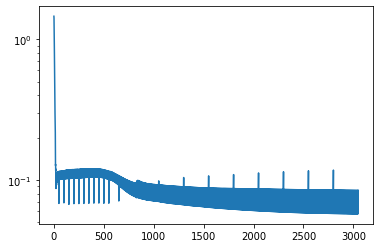

In [231]:
loss_history = np.hstack((loss_history, mynet.train(xy,z,50)))
plt.plot(loss_history);
plt.yscale('log')

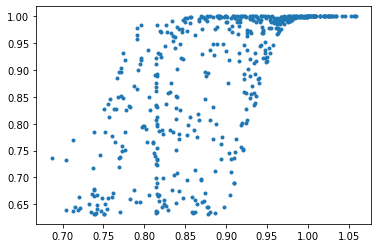

In [232]:
plt.plot(mynet.process(xy),z,'.');

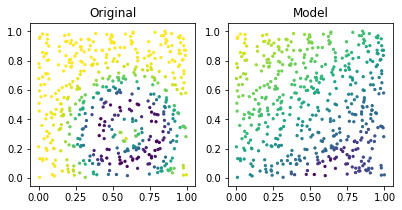

In [233]:
plt.figure(figsize=(6.5,3))
plt.subplot(121);
plt.scatter(xy[:,0], xy[:,1], s=5, c=z);
plt.title('Original');
plt.subplot(122)
plt.scatter(xy[:,0], xy[:,1], s=5, c=mynet.process(xy));
plt.title('Model');

In [ ]:
print(mynet.layers[0])

https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6